In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import jraph
import ase
import ase.io
from ase import Atoms
import tqdm
import matplotlib.pyplot as plt
import sys
import os

from phonax.phonons import (
    atoms_to_ext_graph,
    dynamical_matrix,
)

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)
np.set_printoptions(precision=3, suppress=True)

# Mass-spring phonon model

In this tutorial, we demonstrate the Phonax and JAX framework in deriving the phonon spectrum based on the classic mass-spring model for the atomic vibrations near equilibrium.
In the more expressive energy models as used in the Phonax, interatomic potentials are modeled by the equivariant graph neural networks (for example, NequIP and MACE).
Here we aim to give a simplified tutorial that shows the essential implementation behind phonon derivations for crystals by adopting simple mass-spring models to capture the interatomic potentials.
This can be viewed as the quadratic energy expansion for the energy stored in the nearest neighbor bonds.
With this simplified energy model, we show explicitly how to derive the second derivative Hessians relevant for deriving the phonon spectrum below (which can be viewed as an extension to the force derivations at first order derivatives.)


Below, we show an infinite 1D chain mass-spring model example. 
The phonon spectrum can be derived (see textbook...)

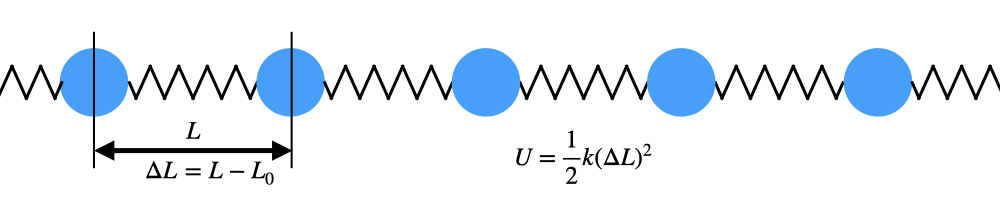





## Energy model definition

Here the energy models are defined by the mass-spring energy stored in the nearest neighbor bonds in a lattice.
The undistorted spring has a natural length $L_0$ at zero energy. When stretched to a length $L$, the spring has an energy 

$$U = \frac{1}{2} k (L-L_0)^2$$

In the function below, we compute the energy stored in the nearest neighbor bonds given by the vectors (and we have assumed $k=0$)



In [2]:
def mass_spring_energy_model(vectors):
    # simple mass and spring model.
    # sping with minimum energy at length = 1.0 (nearest neighbor distance in the test crystals here for simple cubic and fcc)
    vectors_len = jnp.linalg.norm(vectors,axis=1)
    #mask_bonds = ( vectors_len > 1E-2 )
    
    totE = 0.5 * jnp.sum(jnp.square(vectors_len - 1.0)) # * mask_bonds)
    return totE



## Simple periodic lattices

In this tutorial, we demonstrate the phonon derivations for two simple lattice systems: a simple cubic system and a face-centered cubic lattice system.
(we have assumed the lattice sites are decorated by carbon atoms)
Note these are the extended graphs constructed as discussed in our work.
Since the energy only depends on the nearest neighbor bonds, effectively we can treat this as a one step message passing model to aggregate information from just the nearest neighbor bonds.
We have set $L=1$ unit here, and the 1.2 unit radius cutoff would limit to only the nearest neighbor bonds being included.


In [3]:
# generate the graph for a simple cubic lattice
r_max = 1.2
d = 1.0
L = 10.0
cubic_lat = Atoms('C',
             positions=[[0, 0, 0]],
             cell=[d, d, d],
             pbc=[1, 1, 1])

cubic_graph = atoms_to_ext_graph(cubic_lat, r_max, num_message_passing=1)
cubic_masses = ase.data.atomic_masses[cubic_graph.nodes.species][cubic_graph.nodes.mask_primitive]

# generate the graph for a simple FCC lattice
fcc_lat = Atoms('C',
             positions=[[0, 0, 0]],
             cell=np.array([[1.0,1.0,0.0], [0.0,1.0,1.0], [1.0,0.0,1.0]])/np.sqrt(2.0),
             pbc=[1, 1, 1])
fcc_graph = atoms_to_ext_graph(fcc_lat, r_max, num_message_passing=1)
fcc_masses = ase.data.atomic_masses[fcc_graph.nodes.species][fcc_graph.nodes.mask_primitive]




## Phonon Hessian derivation

Here in this step, we construct the function to derive the phonon Hessians by performing proper second order derivatives, given an energy model and the crystal graph.
Note the crystal momentum $q$ is not considered here, as we are only deriving the pairwise second derivatives within the extended crystal graphs.

In [4]:
def predict_hessian_matrix(
    model,  # model(relative_vectors, species, senders, receivers) -> [num_nodes]
    graph: jraph.GraphsTuple,
) -> jax.Array:
    def energy_fn(positions):
        vectors = positions[graph.receivers] - positions[graph.senders]
        graph_energies = model(
            vectors #, graph.nodes.species, graph.senders, graph.receivers
        )  # [n_nodes, ]

        #node_energies = node_energies * graph.nodes.mask_primitive
        #return jnp.sum(node_energies)
        return graph_energies

    basis = jnp.eye(
        graph.nodes.positions.size, dtype=graph.nodes.positions.dtype
    ).reshape(-1, *graph.nodes.positions.shape)

    def body_fn(i, hessian):
        return hessian.at[i].set(
            jax.jvp(
                jax.grad(energy_fn),
                (graph.nodes.positions,),
                (basis[i],),
            )[1]
        )

    hessian = jnp.zeros(
        (graph.nodes.positions.size,) + graph.nodes.positions.shape,
        dtype=graph.nodes.positions.dtype,
    )
    hessian = jax.lax.fori_loop(0, len(basis), body_fn, hessian)
    return hessian.reshape(graph.nodes.positions.shape + graph.nodes.positions.shape)


H_cubic = predict_hessian_matrix(mass_spring_energy_model,cubic_graph)
print(H_cubic.shape)
H_fcc = predict_hessian_matrix(mass_spring_energy_model,fcc_graph)
print(H_fcc.shape)


(7, 3, 7, 3)
(13, 3, 13, 3)


## Phonon spectrum evaluation

Given the second derivative Hessians, one can compute the phonon bands along the high symmetry k path for these crystlas.

In [5]:
# derive the high symmetry k paths

cell = cubic_graph.globals.cell[0]  # [3, 3]
cell = ase.Atoms(cell=cell, pbc=[True,True,True]).cell
rec_vecs_cubic = 2 * np.pi * cell.reciprocal().real
mp_band_path_cubic = cell.bandpath(npoints=300)

cell = fcc_graph.globals.cell[0]  # [3, 3]
cell = ase.Atoms(cell=cell, pbc=[True,True,True]).cell
rec_vecs_fcc = 2 * np.pi * cell.reciprocal().real
mp_band_path_fcc = cell.bandpath(npoints=300)

# modified sqrt function to handle "negative/imaginary" modes in the spectrum
def sqrt(x):
    return jnp.sign(x) * jnp.sqrt(jnp.abs(x))

all_kpts_cubic = mp_band_path_cubic.kpts @ rec_vecs_cubic
all_eigs_cubic = []

for kpt in tqdm.tqdm(all_kpts_cubic):
    # print(kpt)
    Hk = dynamical_matrix(kpt, cubic_graph, H_cubic, masses = np.array([1.0]))
    all_eigs_cubic.append(np.sort(sqrt(np.linalg.eigh(Hk)[0])))

all_eigs_cubic = np.stack(all_eigs_cubic)


bs_cubic = ase.spectrum.band_structure.BandStructure(mp_band_path_cubic, all_eigs_cubic[None])

all_kpts_fcc = mp_band_path_fcc.kpts @ rec_vecs_fcc
all_eigs_fcc = []

for kpt in tqdm.tqdm(all_kpts_fcc):
    # print(kpt)
    Hk = dynamical_matrix(kpt, fcc_graph, H_fcc, masses = np.array([1.0]))
    all_eigs_fcc.append(np.sort(sqrt(np.linalg.eigh(Hk)[0])))

all_eigs_fcc = np.stack(all_eigs_fcc)
bs_fcc = ase.spectrum.band_structure.BandStructure(mp_band_path_fcc, all_eigs_fcc[None])


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 1417.03it/s]


Phonon spectrum plotting


Text(0.5, 1.0, 'Face centered cubic lattice')

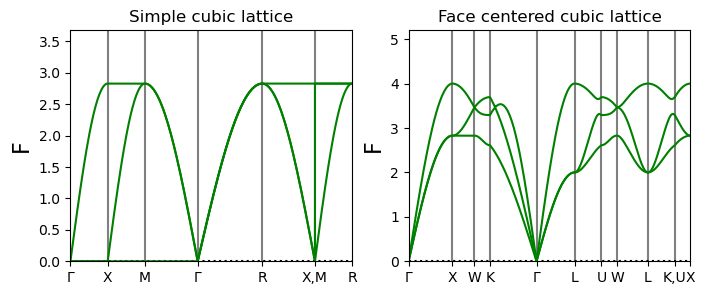

In [6]:
fig, axs = plt.subplots(1,2,figsize=(8, 3), dpi=100)

bs_cubic.plot(ax=axs[0], emin=1.1 * np.min(all_eigs_cubic), emax=1.3 * np.max(all_eigs_cubic))
axs[0].set_ylabel("F",size=16)
axs[0].set_title('Simple cubic lattice')

bs_fcc.plot(ax=axs[1], emin=1.1 * np.min(all_eigs_fcc), emax=1.3 * np.max(all_eigs_fcc))
axs[1].set_ylabel("F",size=16)
axs[1].set_title('Face centered cubic lattice')

## Summary

We hope this tutorial can give a more transparent view of how to derive the necessary second derivative Hessians for phonon spectrum